# Overview

This week we'll talk about advanced network measures (beyond the degree distribution). We will use these tools to make sense of the network of the Country Musicians on Wikipedia. 
This is the outline for today:

* Visualization and qualitative analysis of the Country Music Artists Network
* Properties of the network structure
* Finally some more visualizations

> _Reading_: This week, the reading is mostly for reference. It's for you to have a place to go, if you want more detailed information about the topics that I cover in the video lectures. Thus, I recommend you check out **Chapter 9** of the network science book. In particular, we'll delve into [Section 9.4](http://networksciencebook.com/chapter/9#modularity) in the exercises below. We will also talk a little bit about degree correlations - you can read about those in [Chapter 7](http://networksciencebook.com/chapter/7)\.

In [1]:
import json
import urllib.request
import matplotlib.pyplot as plt
import re
import os
import networkx as nx
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from fa2_modified import ForceAtlas2
import numpy as np
from scipy.stats import spearmanr, pearsonr
import powerlaw
import statistics
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.special import betainc

In [21]:
def wikiinfo(title):
    baseurl =  "https://en.wikipedia.org/w/api.php?"
    action = "action=query"
    title = urllib.parse.urlencode({'titles': title})
    content = "prop=revisions&rvprop=content"
    dataformat ="format=json"
    query = "{}{}&{}&{}&{}".format(baseurl, action, content, title, dataformat)
    wikiresponse = urllib.request.urlopen(query)
    wikidata = wikiresponse.read()
    wikitext = wikidata.decode('utf-8')
    wikijson = json.loads(wikitext)
    return wikijson
wikijson = wikiinfo(title="List_of_country_music_performers")
artist_content = wikijson['query']['pages']['328877']['revisions'][0]['*']
singer_names = re.findall(r'\*\[\[([^\|\(\]]+)', artist_content)
singer_names = sorted(set(singer_names))

def get_connected_names(content):
    # Extract [[...]] from the content and clean by removing parentheses and text after '|'
    matches = re.findall(r'\[\[(.*?)\]\]', content)
    connected_names = [re.sub(r'\(.*?\)|\|.*', '', match).strip() for match in matches]
    return connected_names

def filter_connected_names(connected_names, singer_names):
    # Only keep connected names that are in the singer_names list
    filtered_names = [name for name in connected_names if name in singer_names]
    return filtered_names

def count_words(content):
    # Count the number of words in the content using regex to ignore symbols
    return len(re.findall(r'\b\w+\b', content))

def get_connected_map(folder_path, singer_names):
    # Create a directed graph
    G = nx.DiGraph()
    folder_path = os.path.abspath(folder_path)
    
    # Iterate through all the .txt files in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith(".txt"):
            file_path = os.path.join(folder_path, filename)
            
            if os.path.exists(file_path):
                # Read the file content
                with open(file_path, 'r', encoding='utf-8') as file:
                    content = file.read()
                
                # Use the file name (without .txt) as the node
                filename_m = os.path.splitext(filename)[0]
                
                # Check if the content is empty and set content_length accordingly
                content_length = count_words(content=content) if content.strip() else 0
                
                # Add the node with the content_length as an attribute
                G.add_node(filename_m, content_length=content_length)
                
                # Get and filter the connected names
                connected_names = get_connected_names(content)
                filtered_names = filter_connected_names(connected_names, singer_names)
                
                # Add edges for each filtered name
                for name in filtered_names:
                    G.add_edge(filename_m, name)
            else:
                print(f"File not found: {file_path}")

    return G

# Example usage
folder_path = 'wiki_pages'  # Replace with the actual folder path
G = get_connected_map(folder_path, singer_names)

# You can now work with the graph G
print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

self_loops = list(nx.selfloop_edges(G))  # Get a list of all self-loops
G.remove_edges_from(self_loops)          # Remove self-loops from the graph

Graph has 2090 nodes and 15508 edges.


In [22]:
# Iterate through all nodes and set 'content_length' to 0 if it doesn't exist
for node, data in G.nodes(data=True):
    if 'content_length' not in data:
        G.nodes[node]['content_length'] = 0

# Verify that all nodes now have a 'content_length'
content_lengths = {node: data['content_length'] for node, data in G.nodes(data=True)}

# Print the content length for each node
for node, length in content_lengths.items():
    print(f"Node: {node}, Content Length: {length}")



Node: 3 of Hearts , Content Length: 646
Node: 4 Runner, Content Length: 2538
Node: Tanya Tucker, Content Length: 6289
Node: Diamond Rio, Content Length: 10259
Node: Reba McEntire, Content Length: 21262
Node: Amie Comeaux, Content Length: 889
Node: Chely Wright, Content Length: 12657
Node: Keith Urban, Content Length: 10903
Node: Chad Brock, Content Length: 2020
Node: The Jenkins, Content Length: 554
Node: Craig Morgan, Content Length: 5602
Node: Loretta Lynn, Content Length: 12852
Node: 8 Ball Aitken, Content Length: 1164
Node: A Thousand Horses, Content Length: 2197
Node: Zac Brown Band, Content Length: 9928
Node: Julianne Hough, Content Length: 12343
Node: Lynyrd Skynyrd, Content Length: 9338
Node: Dwight Yoakam, Content Length: 13196
Node: A.P. Carter, Content Length: 4
Node: Aaron Barker, Content Length: 1207
Node: George Strait, Content Length: 14476
Node: Lonestar, Content Length: 0
Node: Doug Supernaw, Content Length: 3492
Node: Clay Walker, Content Length: 7810
Node: Neal McCoy

# Part A: Let's  visualise some more!

Visualization is a big part of network science and (while powerful), the tools built into `NetworkX` are not the most powerful. Therefore, we'll explore another layout in the exercise below. 

Specifically, we will use the [`ForceAtlas2`](https://journals.plos.org/plosone/article%3Fid=10.1371/journal.pone.0098679) package produces som nice layouts. ForceAtlas2 was developed by the creators of the [Gephy graph analysis software](https://gephi.org).

Unfortunately, the canonical version of ForceAtlas on GitHub ([Force Atlas 2 algorithm](https://github.com/bhargavchippada/forceatlas2)) isn't being maintained, so we'll use this fork that's continually updating the original source: https://github.com/AminAlam/fa2_modified below.

**Note**: Finally, I have to say that the Country Music Network is very much a hairball of interconnections, so not even ForceAtlas2 can extract much structure from it. ***But don't worry ... ForceAtlas2 is still worth your time and we'll untangle the hairball in subsequent exercises***.

*Exercise 1:* Plot the Network using ForceAtlas2. For visualization, you should work with the network from last time, the Giant Connected Component ... and the undirected version.

>1. The [Force Atlas 2 algorithm](https://github.com/AminAlam/fa2_modified) helps calculate more aesthetically pleasing positions for the nodes for your network visualizations.
>2. Follow the instructionf on the GitHub page. That page also how to use the package to get coordinates for each node. You can then feed those coordinates to NetworkX (see below).
> * Visualize the network using the [NetworkX draw function](https://networkx.github.io/documentation/stable/reference/generated/networkx.drawing.nx_pylab.draw.html#networkx.drawing.nx_pylab.draw), and node-coordinates from the force atlas algorithm. As in the previous Exercise:
>   * Node color should depend on the `length_of_content` attribute (see notes from last week).
>   * Node size should depend on the node *degree*
> * Play with the force atlas algorithm parameters to obtain a visualization you like. 

<div class="alert alert-block alert-info">
It's OK to use your LLM as much as needed for this exercise. The only goal is to create a nice visualization.
</div>

In [25]:
def apply_force_atlas_layout(G):
    forceatlas2 = ForceAtlas2(
        # Force Atlas 2 settings
        outboundAttractionDistribution=True,
        linLogMode=False,
        adjustSizes=False,
        edgeWeightInfluence=1.0,
        jitterTolerance=1.0,
        barnesHutOptimize=True,
        barnesHutTheta=1.2,
        multiThreaded=False,
        scalingRatio=2.0,
        strongGravityMode=False,
        gravity=1.0,
        verbose=True
    )
    # Get node positions from Force Atlas 2
    positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=2000)
    return positions

# Visualize the network using NetworkX's draw function
def visualize_graph(G, positions):
    fig, ax = plt.subplots(figsize=(12, 12))  # Create a figure and an axis

    # Extract node attributes for visualization
    node_colors = [G.nodes[node]['content_length'] for node in G.nodes()]
    node_sizes = [nx.degree(G, node) * 50 for node in G.nodes()]  # Node size proportional to degree

    # Create the drawing
    cmap = plt.cm.plasma
    nodes = nx.draw(
        G, 
        pos=positions, 
        node_color=node_colors, 
        node_size=node_sizes, 
        cmap=cmap,  # Color based on content length
        with_labels=False, 
        edge_color='gray', 
        alpha=0.7,
        ax=ax  # Ensure nodes are drawn on the same axis
    )

    # Add colorbar based on node color mapping
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(node_colors), vmax=max(node_colors)))
    sm.set_array([])  # Required to add the colorbar
    plt.colorbar(sm, ax=ax, label='Content Length')  # Link colorbar to the specific axis

    plt.title('Network Visualization with Force Atlas 2 Layout')
    plt.show()

# Example usage, assuming positions have been calculated by Force Atlas 2
positions = apply_force_atlas_layout(G)  # Assuming you already calculated positions

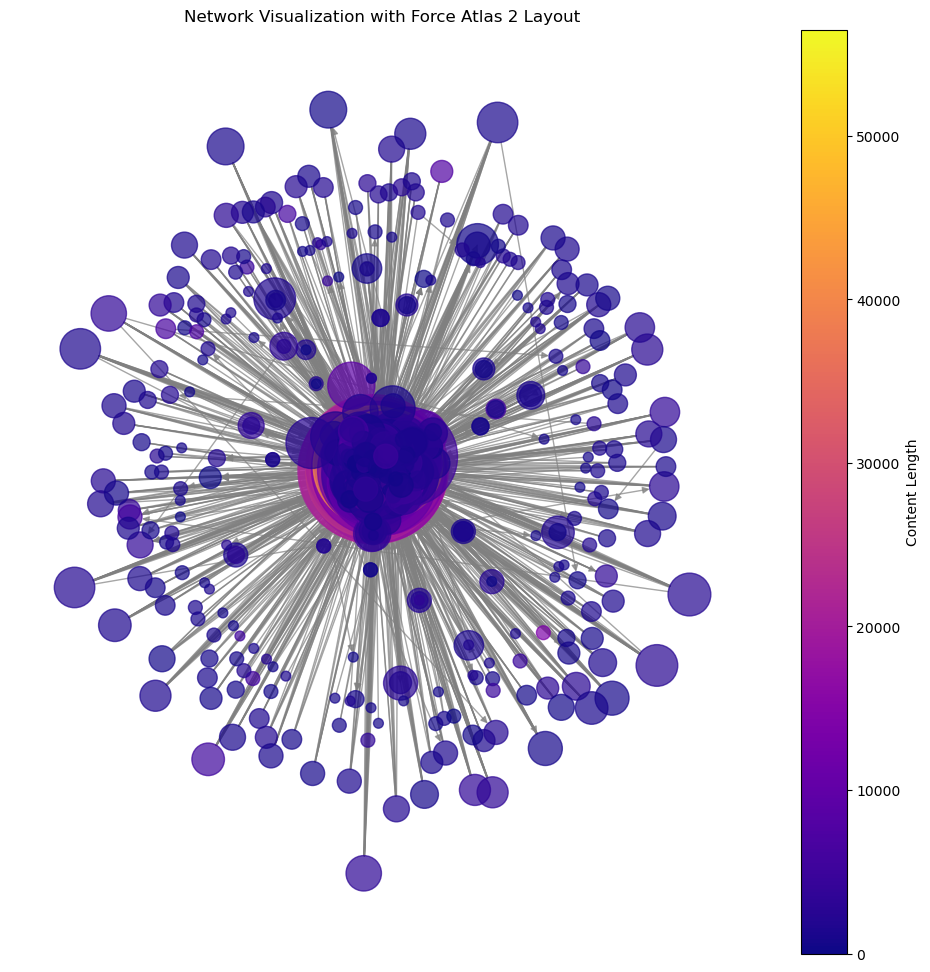

In [26]:
visualize_graph(G, positions)

*Exercise 2*: We continue with a qualitative inspection of the Wikipedia pages. Inspecting the data manually will develop intuitions that will help us to intepret our quantitative results. We investigate the reasons for links between characters to exist on Wikipedia.

> 1. Consider the nodes with highest in-degree in the network. Open the corresponding Wikipedia page.
>    * Consider the set of neighbours pointing towards the node found above. 
>    * What is the relation between the characters you identified and their network neighbours? (e.g. did they sing a song togtether)?, are they opponents?, etc ...). You don't need to come up with a grand theory of Country Music here, I just want you to think about how links arise, why the links are there.
>    * Repeat the exercise for the highest out-degree node. 
>    * Are there differences between reasons for out- and in-links? Again, there's no right answer here. I just want you to think about some of the reasons why links may occur in Wikipedia
> 4. Create a scatter plot, where each node is a point, and the axes show in- versus out-degree. That way you can visually inspect the patterns of how in- and out-degree are connected across all the nodes in the network. Comment on what you see.
> 5. Are there any nodes with high out-degree and with few incoming connections? If yes, open WikiPages of such characters and explain what happens?
> 6. Are there any nodes with high in-degree and few outcoming connections? Again, open WikiPages of such characters and explain what happens?

<div class="alert alert-block alert-info">
For this one, I hope you'll limit your LLM use. It's OK to get help in creating the scatter plot, but use NetworkX on your own to identify nodes, and do your own reading and interpreting of Wiki pages.
</div>

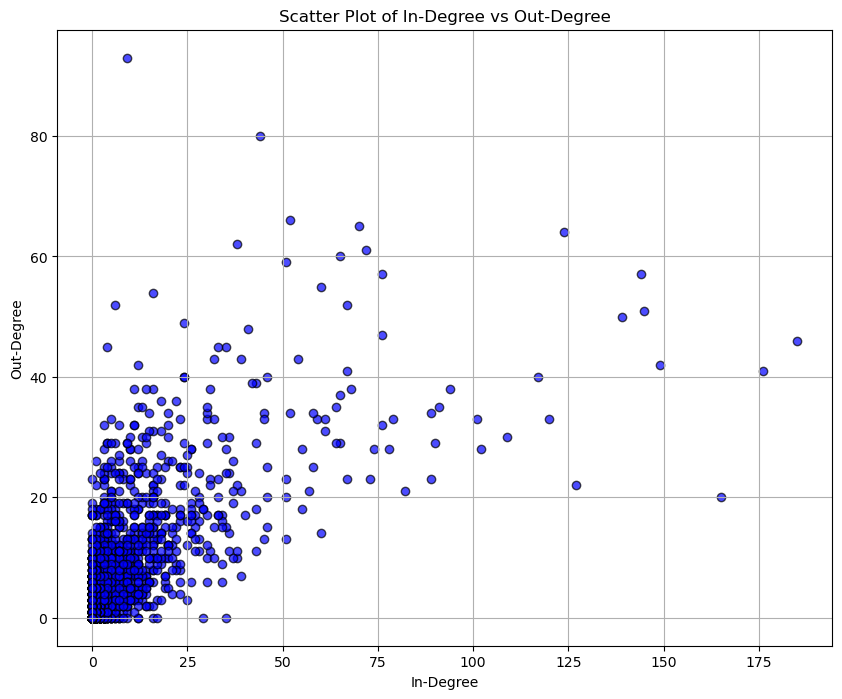

In [27]:
def plot_in_out_degree_scatter(G):
    # Calculate in-degree and out-degree for each node
    in_degrees = dict(G.in_degree())
    out_degrees = dict(G.out_degree())

    # Create scatter plot
    plt.figure(figsize=(10, 8))
    plt.scatter(list(in_degrees.values()), list(out_degrees.values()), alpha=0.7, c='blue', edgecolors='k')

    # Set plot labels and title
    plt.xlabel('In-Degree')
    plt.ylabel('Out-Degree')
    plt.title('Scatter Plot of In-Degree vs Out-Degree')
    plt.grid(True)
    plt.show()

# Example usage
plot_in_out_degree_scatter(G)


# Part B:  Advanced tools 

> **Video lecture**: *Network measures*. There's an updated video below, and if you can't get enough, you can watch the original version from 2015 [here](https://www.youtube.com/watch?v=0uAYpOqVHCU).

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo("IOWXZFOyk9Y", width=800, height=450)

*Exercise 3:* Last time we visually analyzed (plotted) the degree distributions of our network. Now, let's analyze it using some of the tools from previous lectures. For this exercise we are going to look at the *directed* graph (rememeber, we asked you to keep one?).

> 1. What are the average, median, mode, minimum and maximum value of the in-degree? And of the out-degree? How do you intepret the results?
> 2. Let's also look at the *[exponent of the degree distribution](http://networksciencebook.com/chapter/4#degree-exponent)* 
>    * To calculate it, you can install [`powerlaw`](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0085777) package (I could not install in conda, so I used `pip install powerlaw`)
>    * Use `powerlaw.Fit(degree).alpha` for fitting
>    * Find the degree exponent for in-, out- and total- degree distribution. What does it say about our network?
>    * When analyzing the plots of in- and out- degree distribution last week, did you come up to the same conclusions?
>    * A long time ago, a group of scientists analyzed the network spanned by ***all** of Wikipedia (the paper is called [Wikipedias: Collaborative web-based encyclopedias as complex networks](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.74.016115); to access this paper, use findit.dtu.dk or read the preprint on [arXiv](https://arxiv.org/abs/physics/0602149)). Do your findings correspond to the results described in Chapter **III.A** of that paper? If not, try to give your explanation of why? 
> 3. Plot a heatmap [(Hint here)](https://stackoverflow.com/questions/2369492/generate-a-heatmap-in-matplotlib-using-a-scatter-data-set) of the the in- versus out- degree for all characters. Zoom in on just the in-degree $[0,20]$ and out-degree $[0,20]$ area of the plot. What is the advantage of using a heatmap over the scatter plot from the previous Exercise (especially for understanding what's going on in this area)?
> 4. Why do you think I want you guys to use a directed graph? Are there questions we can ask using the directed graph that are not possible to answer in the undirected version? Which questions? Can you think of examples when the in/out distinction doesn't matter.
> 5. We have one more metric that we have used, but not investigated so far. The node-attribute `length_of_content`. There are two things to look at.
>    * Firstly, we can verify that more text means more links. If that's true the length should correlate with out-degree. Does it? 
>    * Secondly, and more interestingly, it could be that longer texts means *more famous* characters. And that means more in-links. 
>    * How should you test this? Well, here you are allowed to be **creative**. You may choose the method of your liking to study this question (e.g. look at it visually, test the correlation using [spearman](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html) or [pearson](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.pearsonr.html) correlations, fit a curve to the data, you decide). Once you've tested, let me know. Are both questions true? If yes, which phenomenon is stronger? Explain your results in your own words.

<div class="alert alert-block alert-info">
For this exercise, I also hope you'll limit your LLM use. Especially for the intrepretation parts. It's OK to get help for the heatmap in sub-part 3, maybe also for ideas of how to do the testing in part 5. But do your own interpretation :)
</div>

*Exercise 4:* Centralities, assortativity and more.

Earlier, we found the most connected nodes (using degree centrality). 

Now let's dig in and try to understand more about the network using more advanced features. 

**Note**: Not all of the measures we'll be considering below are defined for directed graphs. Only use the undirected graph when explicitly stated in the exercise. 
> 1. Find the 5 most central characters according to degree centrality. 
> 1. Find the 5 most central characters according to betweenness centrality. 
>    * Repeat Exercise 1. However, this time use *betweenness centrality* to define the size of the node.
>    * What role do you imagine characters with high wikipedia graph betweenness centrality play in the network? 
> 2. Find the 5 most central characters according to eigenvector centrality. Calculate centrality corresponding to both in- and out-edges (see NetworkX documentation for details). 
>    * Repeat Exercise 1 one final time (depending on which visualization method you liked the most). However, this time use eigenvector centrality to define the size of the node.
>    * What role do you imagine characters with high wikipedia graph eigenvector centrality play? Describe what is different about betweenness centrality and eigenvector centrality using your visualizations as examples.
> 3. Plot the betweenness centrality of nodes vs their degree centrality. Is there a correlation between the two? Did you expect that? Why? 
>     * Repeat the scatter plot using eigenvector centrality instead of betweenness centrality. Do you observe any difference relative to above? Why?
> 4. Is the undirected version of the graph [assortative](https://en.wikipedia.org/wiki/Assortativity) with respect to degree? (e.g. do high-degree characters tend to link to other high-degree characters, and low-degree characters to other low-degree characters?). Provide an interpretation of your answer.
> 5. Is the undirected version of the graph [assortative](https://en.wikipedia.org/wiki/Assortativity) with respect do the `length_of_content` nodal properties? (e.g. do characters with long Wikipedia pages tend to link to other charakters with long Wiki-pages, and *vice versa*?.
>      * Hint: Use [this function](https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.assortativity.attribute_assortativity_coefficient.html#networkx.algorithms.assortativity.attribute_assortativity_coefficient). Provide an interpretation of your answer.
> 6. What is the average shortest path length? Is it similar to the one of a random graph with the same number of nodes $N$  and probablity of connection $p$?
>    * Take a look at the *distribution* of shortest paths for the two networks (create a histogram for each network) to better compare and contrast. Explain what you see in your own words.

<div class="alert alert-block alert-info">
As in the two previous exercises, I hope you'll limit your LLM use. Try to get a sense of working with NetworkX. And to grow your brain, do your own intrepretation parts ... it's difficult, but that's how you grow.</div>

In [29]:

def degree_statistics(G):
    # Get the in-degree and out-degree for all nodes
    in_degrees = [deg for node, deg in G.in_degree()]
    out_degrees = [deg for node, deg in G.out_degree()]
    
    # In-degree statistics
    in_stats = {
        'average': np.mean(in_degrees),
        'median': np.median(in_degrees),
        'mode': statistics.mode(in_degrees),
        'min': np.min(in_degrees),
        'max': np.max(in_degrees)
    }
    
    # Out-degree statistics
    out_stats = {
        'average': np.mean(out_degrees),
        'median': np.median(out_degrees),
        'mode': statistics.mode(out_degrees),
        'min': np.min(out_degrees),
        'max': np.max(out_degrees)
    }
    
    return in_stats, out_stats

# Example usage
in_stats, out_stats = degree_statistics(G)

print("In-degree stats:", in_stats)
print("Out-degree stats:", out_stats)


In-degree stats: {'average': 7.277511961722488, 'median': 2.0, 'mode': 0, 'min': 0, 'max': 185}
Out-degree stats: {'average': 7.277511961722488, 'median': 4.0, 'mode': 0, 'min': 0, 'max': 93}


In [30]:


def fit_powerlaw(degrees):
    fit = powerlaw.Fit(degrees)
    return fit.alpha

# Example usage
in_degrees = [deg for node, deg in G.in_degree()]
out_degrees = [deg for node, deg in G.out_degree()]
total_degrees = [deg for node, deg in G.degree()]

in_alpha = fit_powerlaw(in_degrees)
out_alpha = fit_powerlaw(out_degrees)
total_alpha = fit_powerlaw(total_degrees)

print("In-degree exponent (alpha):", in_alpha)
print("Out-degree exponent (alpha):", out_alpha)
print("Total-degree exponent (alpha):", total_alpha)


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
In-degree exponent (alpha): 2.644773348763116
Out-degree exponent (alpha): 4.98265948043827
Total-degree exponent (alpha): 2.9430506723089147


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


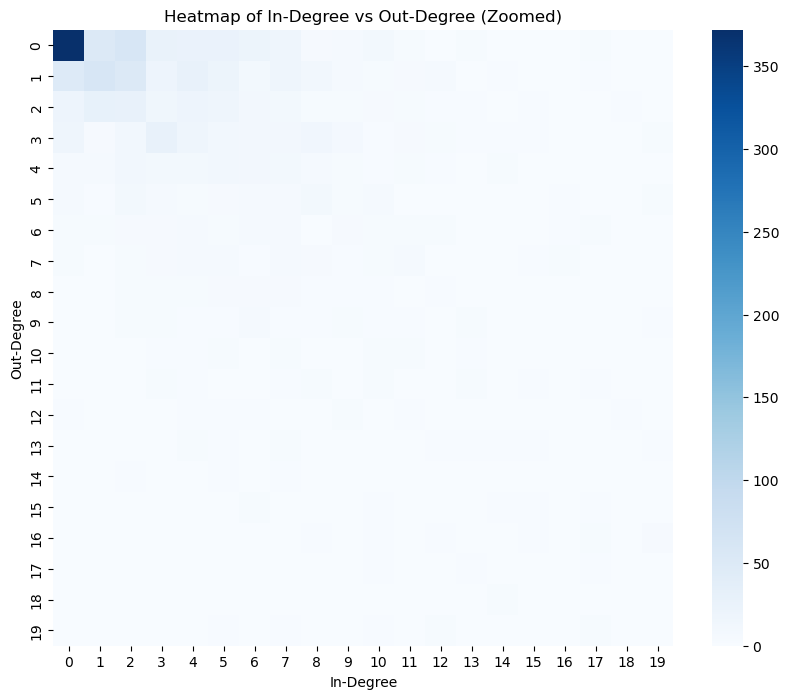

In [31]:

def plot_heatmap(G):
    # Get in-degree and out-degree pairs
    in_degrees = [deg for node, deg in G.in_degree()]
    out_degrees = [deg for node, deg in G.out_degree()]
    
    # Create a 2D histogram of in-degree and out-degree
    heatmap_data = np.histogram2d(in_degrees, out_degrees, bins=(20, 20), range=[[0, 20], [0, 20]])

    # Plot heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(heatmap_data[0], annot=False, cmap='Blues')
    plt.xlabel('In-Degree')
    plt.ylabel('Out-Degree')
    plt.title('Heatmap of In-Degree vs Out-Degree (Zoomed)')
    plt.show()

# Example usage
plot_heatmap(G)


In [32]:
def test_correlation(G):
    content_lengths = [G.nodes[node]['content_length'] for node in G.nodes()]
    out_degrees = [deg for node, deg in G.out_degree()]
    in_degrees = [deg for node, deg in G.in_degree()]
    
    # Spearman correlation
    out_corr_spearman, _ = spearmanr(content_lengths, out_degrees)
    in_corr_spearman, _ = spearmanr(content_lengths, in_degrees)

    # Pearson correlation
    out_corr_pearson, _ = pearsonr(content_lengths, out_degrees)
    in_corr_pearson, _ = pearsonr(content_lengths, in_degrees)

    print(f"Spearman correlation between content length and out-degree: {out_corr_spearman}")
    print(f"Spearman correlation between content length and in-degree: {in_corr_spearman}")
    print(f"Pearson correlation between content length and out-degree: {out_corr_pearson}")
    print(f"Pearson correlation between content length and in-degree: {in_corr_pearson}")

# Example usage
test_correlation(G)


Spearman correlation between content length and out-degree: 0.6900718648340987
Spearman correlation between content length and in-degree: 0.6432669972337002
Pearson correlation between content length and out-degree: 0.48255588282110273
Pearson correlation between content length and in-degree: 0.555647983523901


In [33]:
# Find the top 5 characters by degree centrality
degree_centrality = nx.degree_centrality(G)
top_5_degree_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]

print("Top 5 characters by degree centrality:")
for character, centrality in top_5_degree_centrality:
    print(f"{character}: {centrality}")


Top 5 characters by degree centrality:
Willie Nelson: 0.1105792245093346
Johnny Cash: 0.1038774533269507
Merle Haggard: 0.09621828626136908
George Jones: 0.09382479655337482
Dolly Parton: 0.09143130684538056


Top 5 characters by betweenness centrality:
Merle Haggard: 0.02545433685918219
Vince Gill: 0.023179801610606177
Willie Nelson: 0.021171853897466765
Johnny Cash: 0.020044699796563537
Toby Keith: 0.018208449182806206


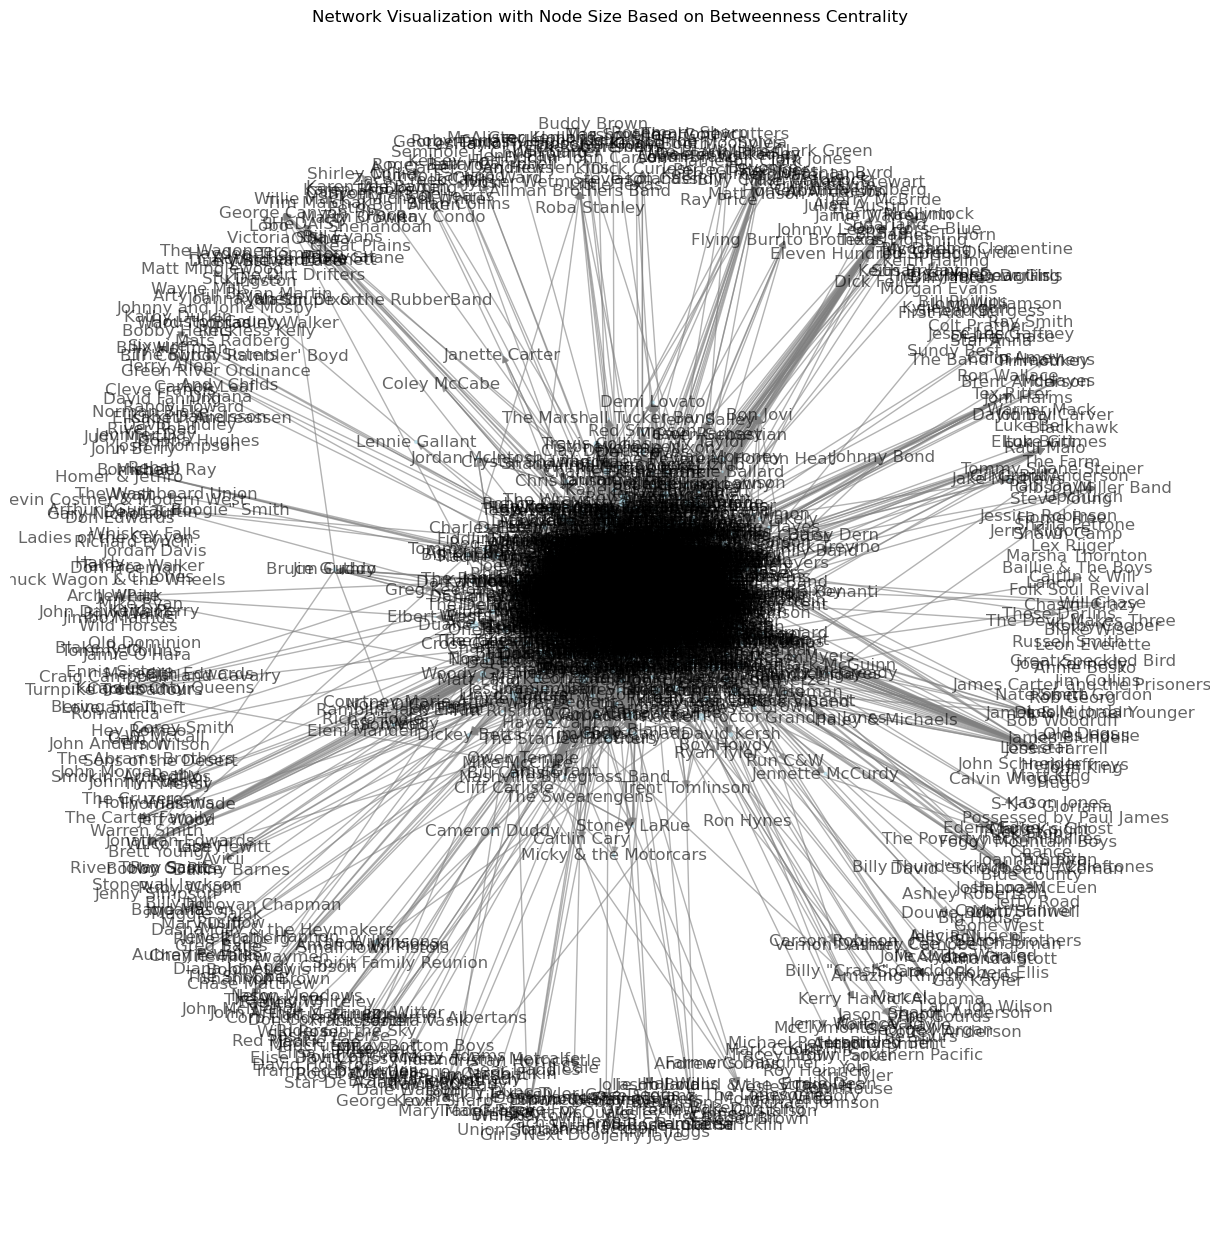

In [34]:
# Find the top 5 characters by betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G)
top_5_betweenness_centrality = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]

print("Top 5 characters by betweenness centrality:")
for character, centrality in top_5_betweenness_centrality:
    print(f"{character}: {centrality}")
def visualize_betweenness_centrality(G, positions):
    betweenness_centrality = nx.betweenness_centrality(G)
    node_sizes = [10000 * betweenness_centrality[node] for node in G.nodes()]
    
    plt.figure(figsize=(12, 12))
    nx.draw(
        G, pos=positions, node_size=node_sizes, node_color='lightblue', 
        with_labels=True, edge_color='gray', alpha=0.6
    )
    plt.title("Network Visualization with Node Size Based on Betweenness Centrality")
    plt.show()

# Visualize
positions = nx.spring_layout(G)  # Layout of the graph
visualize_betweenness_centrality(G, positions)

Top 5 characters by eigenvector centrality:
Johnny Cash: 0.22142313562537652
Willie Nelson: 0.20618108964354429
Elvis Presley: 0.19999534181552828
Vince Gill: 0.19744833305502693
Dolly Parton: 0.19271306835491575


c:\Users\wuqiu\anaconda3\lib\site-packages\matplotlib\collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
c:\Users\wuqiu\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:767: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(marker_size) / 2


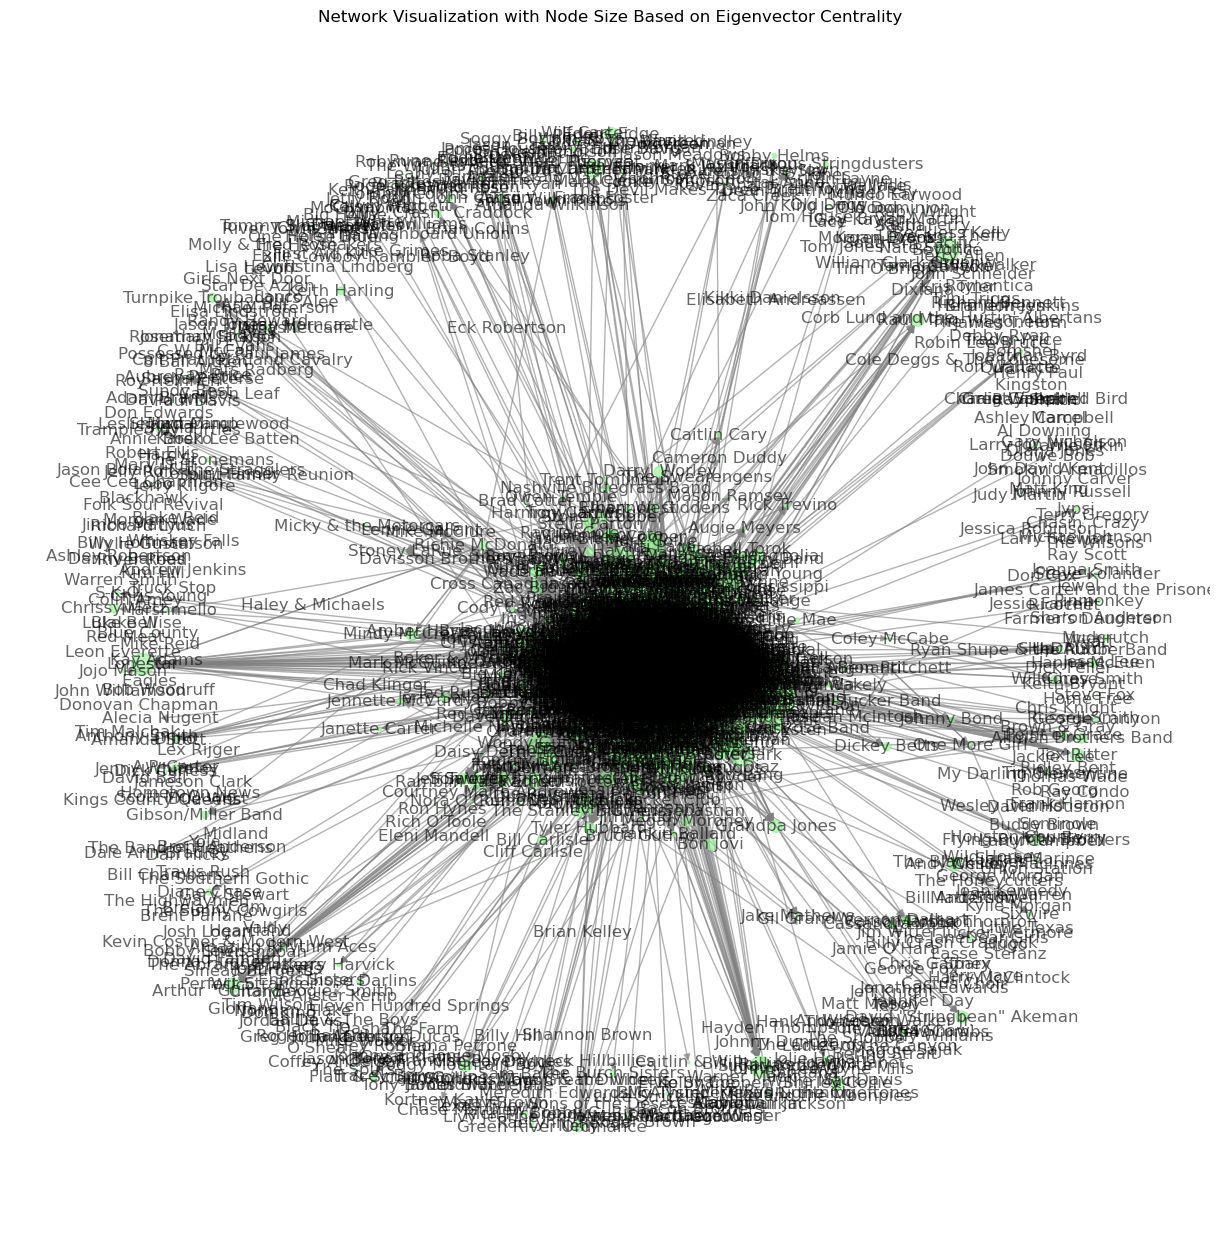

In [52]:
# Find the top 5 characters by eigenvector centrality (directed graph)
eigenvector_centrality = nx.eigenvector_centrality_numpy(G)
top_5_eigenvector_centrality = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)[:5]

print("Top 5 characters by eigenvector centrality:")
for character, centrality in top_5_eigenvector_centrality:
    print(f"{character}: {centrality}")
def visualize_eigenvector_centrality(G, positions):
    eigenvector_centrality = nx.eigenvector_centrality_numpy(G)
    node_sizes = [10000 * eigenvector_centrality[node] for node in G.nodes()]

    plt.figure(figsize=(12, 12))
    nx.draw(
        G, pos=positions, node_size=node_sizes, node_color='lightgreen', 
        with_labels=True, edge_color='gray', alpha=0.6
    )
    plt.title("Network Visualization with Node Size Based on Eigenvector Centrality")
    plt.show()

# Visualize
positions = nx.spring_layout(G)
visualize_eigenvector_centrality(G, positions)


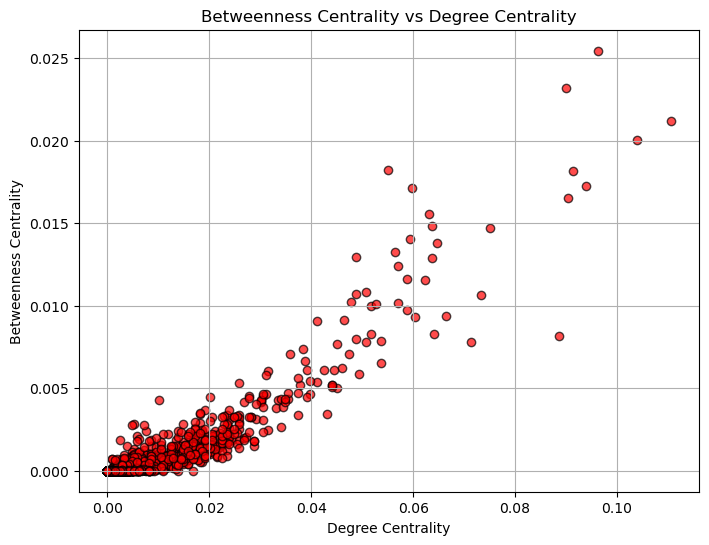

In [53]:
def plot_betweenness_vs_degree(G):
    degree_centrality = nx.degree_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G)

    # Scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(list(degree_centrality.values()), list(betweenness_centrality.values()), alpha=0.7, c='red', edgecolors='k')
    plt.xlabel('Degree Centrality')
    plt.ylabel('Betweenness Centrality')
    plt.title('Betweenness Centrality vs Degree Centrality')
    plt.grid(True)
    plt.show()

# Plot
plot_betweenness_vs_degree(G)


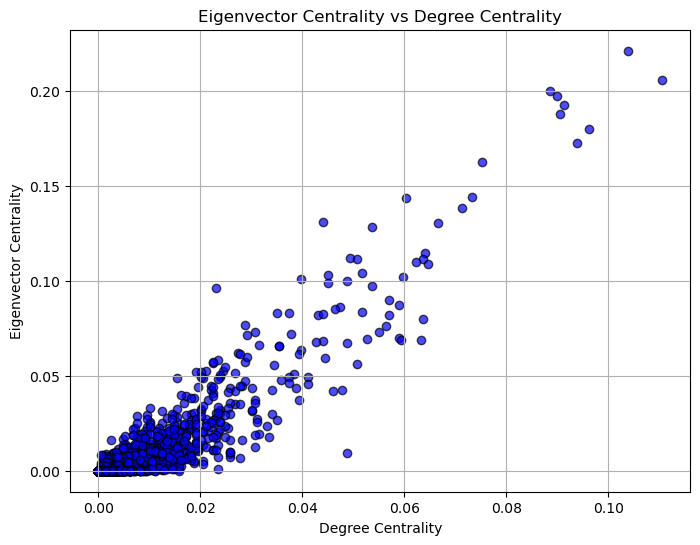

In [54]:
def plot_eigenvector_vs_degree(G):
    degree_centrality = nx.degree_centrality(G)
    eigenvector_centrality = nx.eigenvector_centrality_numpy(G)

    # Scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(list(degree_centrality.values()), list(eigenvector_centrality.values()), alpha=0.7, c='blue', edgecolors='k')
    plt.xlabel('Degree Centrality')
    plt.ylabel('Eigenvector Centrality')
    plt.title('Eigenvector Centrality vs Degree Centrality')
    plt.grid(True)
    plt.show()

# Plot
plot_eigenvector_vs_degree(G)


Degree assortativity coefficient: -0.030774594044376942
Content length assortativity coefficient: -0.0016072590793444425
Average shortest path length: 3.1036647148467584
Average shortest path length for random graph: 3.017792376977993


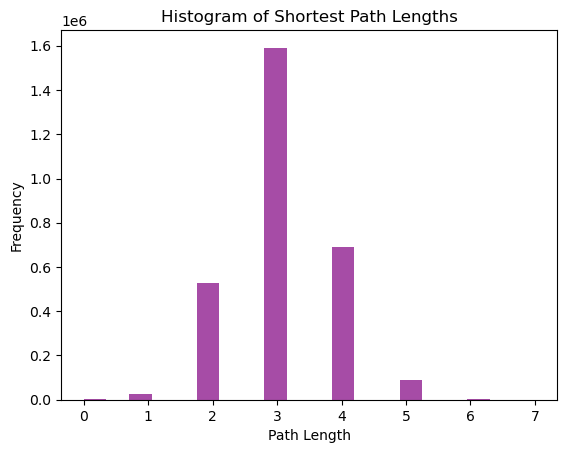

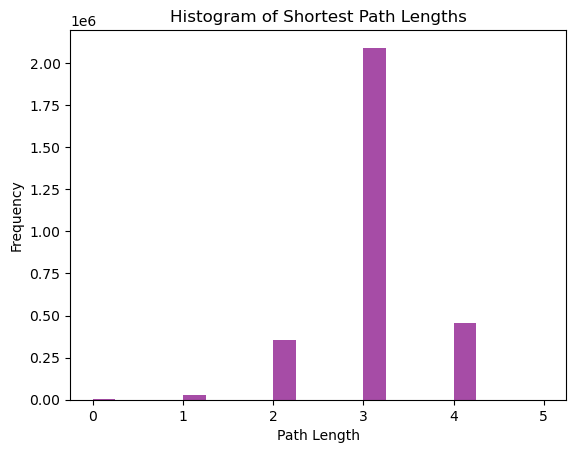

In [58]:

# For the undirected version of the graph
G_undirected = G.to_undirected()

# Find the largest connected component
largest_cc = max(nx.connected_components(G_undirected), key=len)
G_largest_cc = G_undirected.subgraph(largest_cc).copy()

# Degree assortativity
degree_assortativity = nx.degree_assortativity_coefficient(G_largest_cc)
print(f"Degree assortativity coefficient: {degree_assortativity}")

# Set default content_length to 0 if not present
for node in G_largest_cc.nodes():
    if 'content_length' not in G_largest_cc.nodes[node]:
        G_largest_cc.nodes[node]['content_length'] = 0

# Assortativity based on content length
attribute_assortativity = nx.attribute_assortativity_coefficient(G_largest_cc, 'content_length')
print(f"Content length assortativity coefficient: {attribute_assortativity}")

# Average shortest path length for the largest connected component
avg_shortest_path_length = nx.average_shortest_path_length(G_largest_cc)
print(f"Average shortest path length: {avg_shortest_path_length}")

# Compare with random graph
N = G_largest_cc.number_of_nodes()
p = nx.density(G_largest_cc)  # Probability of connection
random_graph = nx.gnp_random_graph(N, p)

random_avg_shortest_path_length = nx.average_shortest_path_length(random_graph)
print(f"Average shortest path length for random graph: {random_avg_shortest_path_length}")

# Function to plot the histogram of shortest path lengths
def plot_shortest_path_histogram(G):
    lengths = dict(nx.shortest_path_length(G))
    all_lengths = []
    
    for node, paths in lengths.items():
        all_lengths.extend(paths.values())

    plt.hist(all_lengths, bins=20, alpha=0.7, color='purple')
    plt.title('Histogram of Shortest Path Lengths')
    plt.xlabel('Path Length')
    plt.ylabel('Frequency')
    plt.show()

# Plot histogram for shortest path lengths
plot_shortest_path_histogram(G_largest_cc)
plot_shortest_path_histogram(random_graph)


# Part C: Backbones and Network Visualization 

One method to clean up the "hairball"-looking networks, is known as the [backbone method](https://www.pnas.org/doi/10.1073/pnas.0808904106). Sometimes this method is also the "disparity filter". I explain what it's all about in the video below.

In [ ]:
YouTubeVideo("GOvsrVulbsg", width=800, height=450)

We only have one problem. As I explain in the video, the Backbone / Disparity Filter method *only works on weighted networks*. Our network does not have meaningful edge weights (since there's usually just a single link between two wiki pages), so as an experiment, we'll add weights proportional to the [edge betweenness centrality](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.edge_betweenness_centrality.html). The edge betweenness centrality is just like the node betweenness centrality that you know and love ... only that it's defined for edges instead of nodes.

Let's create two new weighted networks
 * **Weighted Network 1**: The ***undirected*** Country Music Network (Giant Connected Component) but with edge weights proportional to the edge betweenness centrality (let's renormalize so that the lowest weight is equal to 1 and the highest weight is equal to 100).
 * **Weighted Network 2**: The ***undirected*** Country Music Network  (Giant Connected Component) but with edge weights proportional to 1/(edge weight in Weighted Network 1).

Now we're ready for the exercise.


*Exercise 5*: Visualizing the Network Backbone

> 1. Extract the network backbone for both Weighted Network 1 and 2. You can implement it yourself based on the [scientific paper](https://www.pnas.org/doi/10.1073/pnas.0808904106) or find an implentation on GitHub (there are several ones to choose from ... I like [this implementation](https://www.michelecoscia.com/?page_id=287), which also includes other interesting edge filters). Figure out how your particular backbone extractor works (you may have to inspect the code itself, these packages are not always well documented). Play around with values of $\alpha$ to get an aestetically pleasing visualization (but don't make the resulting network too sparse).
> 2. Plot the resulting two networks using ForceAtlas2, still sizing nodes according to total degree. No need to color them. If your backbone has some disconnected nodes, feel free to not plot them. And remember to calculate a new layout to see how the structure has changed.
> 3. Comment on your results
>    * Do you see any structures in the networks now? Inspect some nodes to get a sense of what the structures captures in the two networks. Describe your findings in your own words.
>    * Weighted network 1 and 2 are very different. We have removed edges with low/high edge betweenness centrality respectively. What has that done to the networks? Describe what you see visually, and your explain your thoughts on what we've done to the network structure.

<div class="alert alert-block alert-info">
There's a lot to do today, so knock youself out with your LLM for this exercise, hopefully it can make your life easier (although I hope you'll do a bit of your own thinking, since a lot of complicated conceptual things are going on with the interplay between the backboning and edge betweenness and inverse edge betweenness!)</div>

One final thing. For now, the backbone is only for visualization. Especially because the edge weights are a bit artificial. Generally, it's not exactly clear what kind of information we get rid off when removing the non-backbone edges -- and in our case it's even less clear. Thus, we'll still do the exercises during the following weeks using the full network that preserves all of the connection information.


In [41]:
# Function to normalize weights between a given range
def normalize_weights(weights, new_min=1, new_max=100):
    old_min, old_max = min(weights), max(weights)
    return [(new_min + (w - old_min) * (new_max - new_min) / (old_max - old_min)) for w in weights]

# Create Weighted Network 1 (based on edge betweenness centrality)
def create_weighted_network_1(G):
    # Calculate edge betweenness centrality for all edges
    edge_betweenness = nx.edge_betweenness_centrality(G)
    
    # Normalize the edge betweenness centrality to a range [1, 100]
    normalized_betweenness = normalize_weights(list(edge_betweenness.values()))
    
    # Create a new weighted graph
    weighted_G1 = nx.Graph()  # We want this to be undirected
    for i, (u, v) in enumerate(edge_betweenness.keys()):
        weighted_G1.add_edge(u, v, weight=normalized_betweenness[i])
    
    return weighted_G1

# Create Weighted Network 2 (inverse of edge weights in Weighted Network 1)
def create_weighted_network_2(weighted_G1):
    weighted_G2 = nx.Graph()  # Undirected
    for u, v, data in weighted_G1.edges(data=True):
        original_weight = data['weight']
        inverted_weight = 1.0 / original_weight  # Inverse of the weight
        weighted_G2.add_edge(u, v, weight=inverted_weight)
    
    return weighted_G2

# Assuming G is your undirected giant connected component
weighted_G1 = create_weighted_network_1(G)
weighted_G2 = create_weighted_network_2(weighted_G1)

print("Created Weighted Network 1 and Weighted Network 2")


Created Weighted Network 1 and Weighted Network 2


In [50]:
def disparity_filter(G, alpha=0.05):
    """
    Apply the disparity filter to extract the network backbone.
    Only edges with a significance score lower than alpha are retained.
    """
    backbone = nx.Graph()  # Create an empty graph for the backbone
    
    for node in G.nodes():
        neighbors = list(G.neighbors(node))
        if len(neighbors) > 1:
            k = len(neighbors)
            weight_sum = sum(G[node][nbr]['weight'] for nbr in neighbors)
            for nbr in neighbors:
                weight = G[node][nbr]['weight']
                p = 1 - (1 - (weight / weight_sum)) ** (k - 1)
                
                # Calculate the significance (alpha significance level test)
                if p < alpha:
                    backbone.add_edge(node, nbr, weight=weight)
    
    return backbone

# Apply the disparity filter to both weighted networks
# Use a higher alpha value to keep more edges (e.g., alpha=0.1)
backbone_G1 = disparity_filter(weighted_G1, alpha=0.5)
backbone_G2 = disparity_filter(weighted_G2, alpha=0.5)


print("Backbones for Weighted Networks 1 and 2 extracted using manual disparity filter")


Backbones for Weighted Networks 1 and 2 extracted using manual disparity filter


100%|██████████| 2000/2000 [02:48<00:00, 11.86it/s]


BarnesHut Approximation  took  18.70  seconds
Repulsion forces  took  144.23  seconds
Gravitational forces  took  0.45  seconds
Attraction forces  took  0.42  seconds
AdjustSpeedAndApplyForces step  took  1.78  seconds


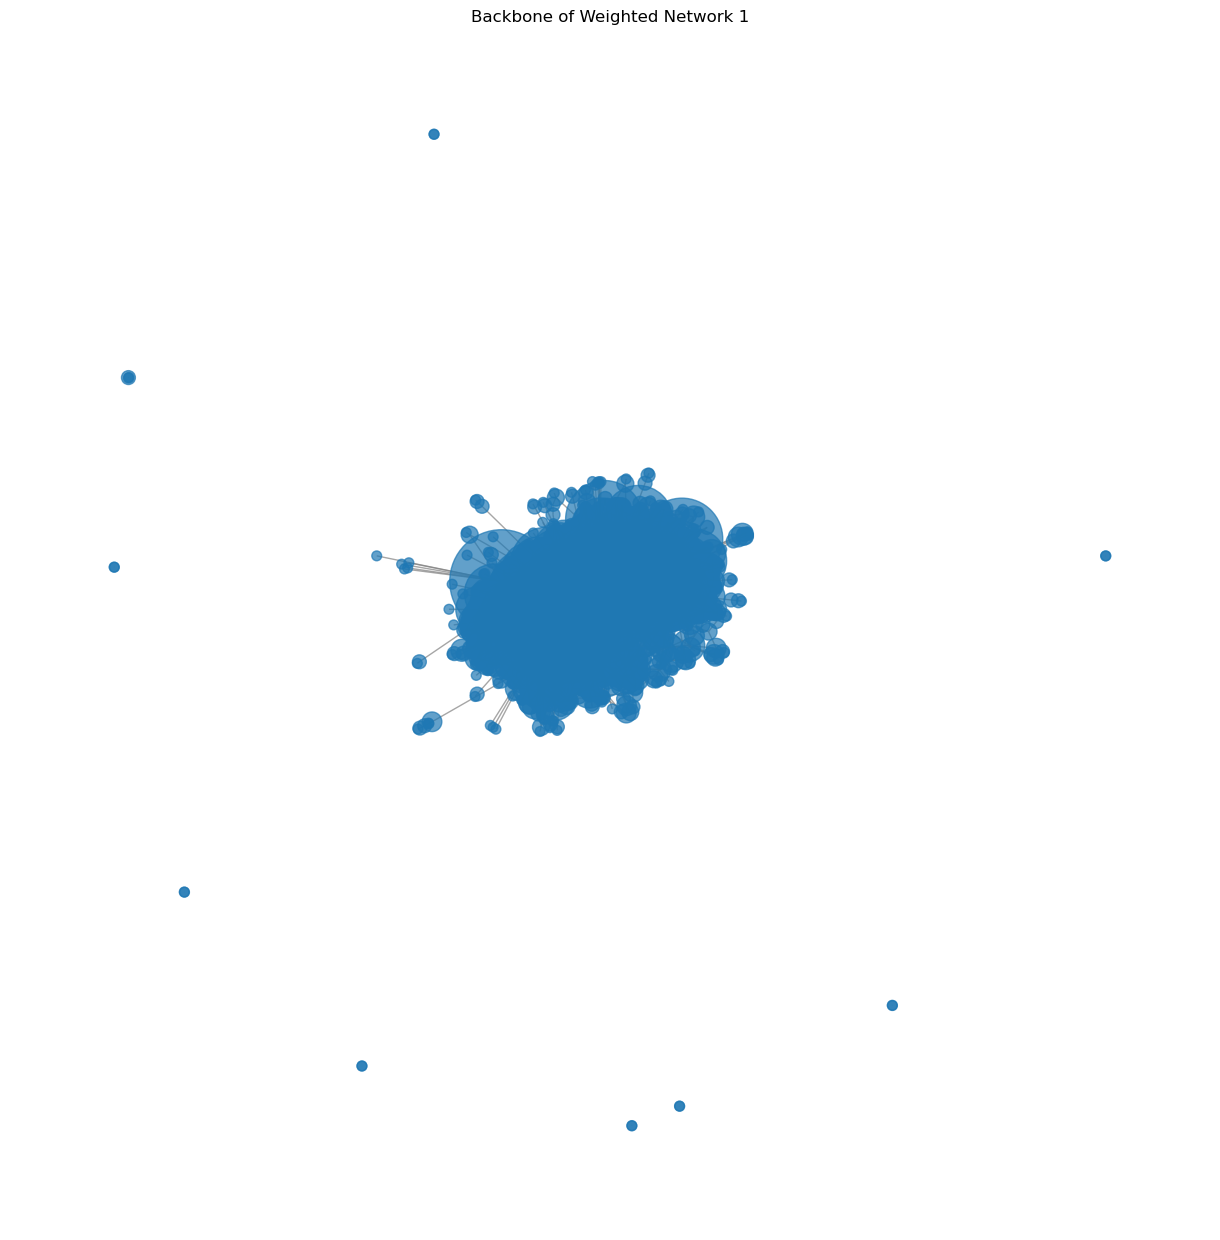

100%|██████████| 2000/2000 [02:38<00:00, 12.59it/s]


BarnesHut Approximation  took  20.81  seconds
Repulsion forces  took  132.08  seconds
Gravitational forces  took  0.47  seconds
Attraction forces  took  0.34  seconds
AdjustSpeedAndApplyForces step  took  2.09  seconds


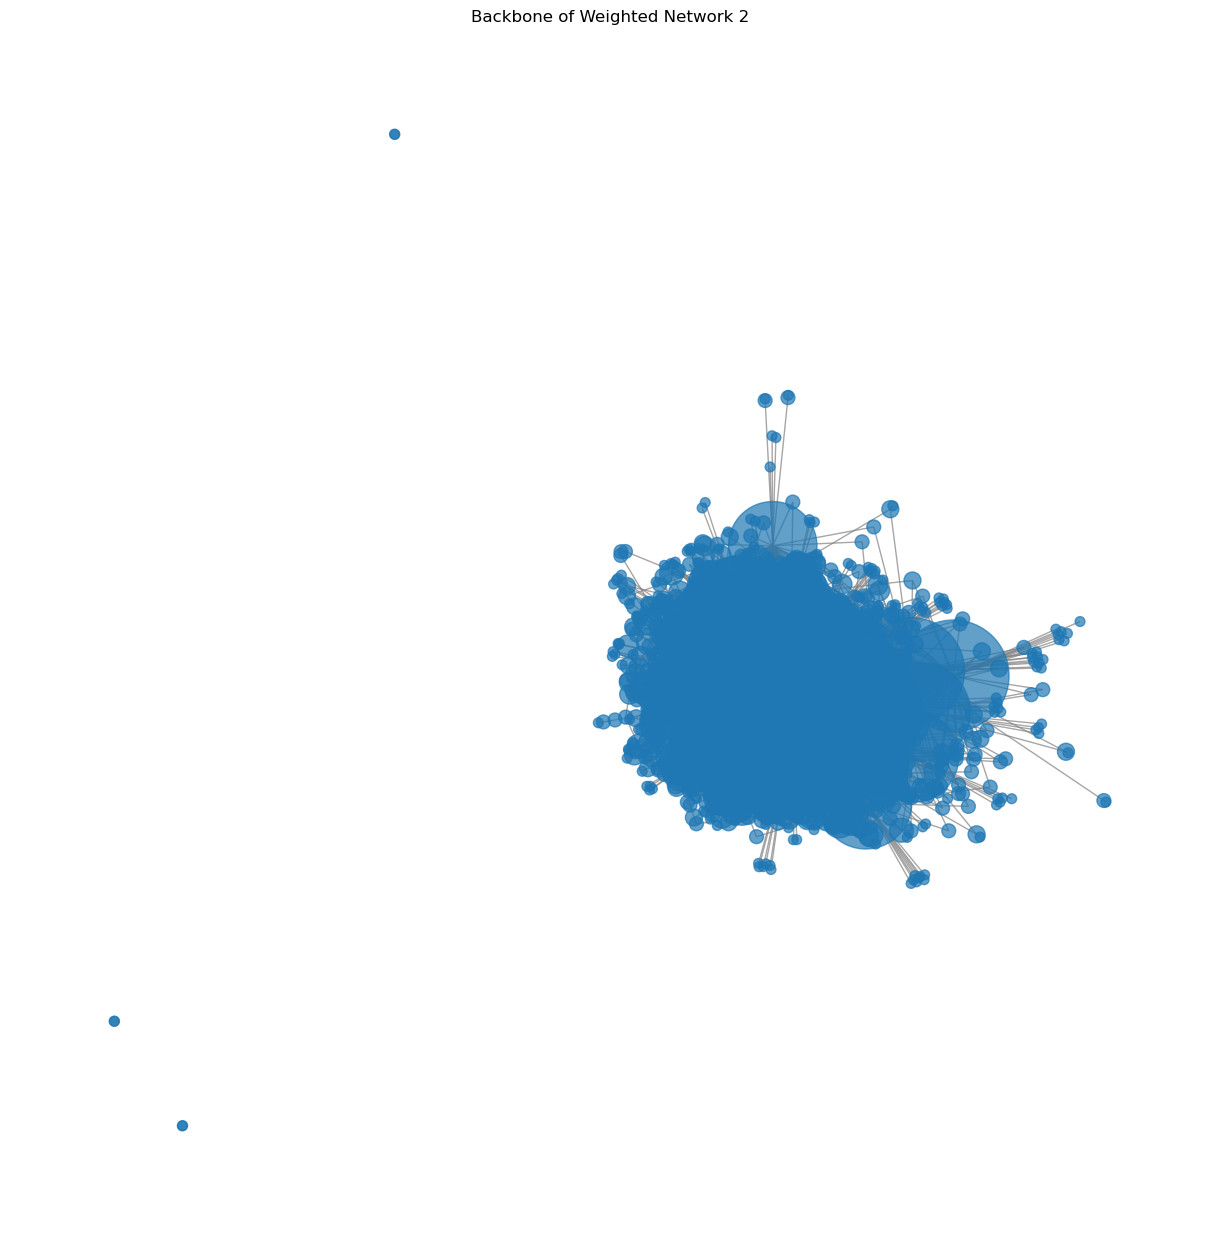

In [51]:
# Function to apply ForceAtlas2 layout and visualize the graph
def visualize_forceatlas2(G, title):
    # Apply ForceAtlas2 layout
    forceatlas2 = ForceAtlas2(
        outboundAttractionDistribution=True,
        linLogMode=False,
        adjustSizes=False,
        edgeWeightInfluence=1.0,
        jitterTolerance=1.0,
        barnesHutOptimize=True,
        barnesHutTheta=1.2,
        scalingRatio=2.0,
        strongGravityMode=False,
        gravity=1.0,
        verbose=True
    )
    
    positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=2000)
    
    # Plot the graph
    plt.figure(figsize=(12, 12))
    node_sizes = [nx.degree(G, node) * 50 for node in G.nodes()]
    nx.draw(G, pos=positions, node_size=node_sizes, with_labels=False, edge_color='gray', alpha=0.7)
    plt.title(title)
    plt.show()

# Visualize Backbone of Weighted Network 1
visualize_forceatlas2(backbone_G1, 'Backbone of Weighted Network 1')

# Visualize Backbone of Weighted Network 2
visualize_forceatlas2(backbone_G2, 'Backbone of Weighted Network 2')
